# Generating the Wireless Channel for Mobile Users

**Objective**

- Generate Channel for Mobile users
- Variation in power with time.

* In this tutorial, we will learn how to generate a channel for mobile users and analyze how the power received by users moving vary over time.

* To set up a simulation, we consider a layout having a 3 sector Hexagonal geometry, where the Base Stations are located at the center of hexagon covering each sector and a single User Equipment (UE)   moving on a circular trajectory.

* We choose RuralMacro (RMa) terrain with a carrier frequency of 3 GHz for simulation.


* We also choose omni directional dipole antenna for Receiver (Rx) and a parabolic antenna for Transmitter (Tx).


* We first import the necessary libraries followed by creating objects of classes `AntennaArrays`, `NodeMobility`, and `SimulationLayout` respectively


The content of the tutorial is as follows:

**Table Of Content**

* [Python Libraries](#import-python-libraries)
* [5G Toolkit Libraries](#import-5G-toolkit-libraries)
* [Simulation Parameters](#simulation-parameters)
* [Antenna Array Objects](#antenna-array-obj)
* [Node Mobility Objects](#node-mobility-obj)
* [Simulation Layout Object](#simulation-layout-obj)
* [Channel Parameters](#lsp-ssp)
* [Channel Coefficients](#clusterlevel-channelcoeff)
* [Power variations across time](#power-variations-with-time)


## Import Libraries
### Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

%matplotlib widget
import matplotlib.pyplot    as plt
import matplotlib.patches   as patches
import matplotlib.animation as animation
import numpy as np

### 5G Toolkit Libraries

In [2]:

from toolkit5G.ChannelModels import NodeMobility
from toolkit5G.ChannelModels import AntennaArrays
from toolkit5G.ChannelModels import SimulationLayout
from toolkit5G.ChannelModels import ParameterGenerator
from toolkit5G.ChannelModels import ChannelGenerator


In [3]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

## Simulation Parameters

Define the following Simulation Parameters:

  * ``propTerrain`` defines propagation terrain for BS-UE links
  * ``carrierFrequency`` defines  carrier frequency in Hz
  * ``nBSs`` defines number of Base Stations (BSs)
  * ``nUEs`` defines number of User Equipments (UEs) 
  * ``nSnapShots`` defines number of SnapShots, where SnapShots correspond to different time-instants at which a mobile user channel is being generated. 

In [4]:
# Simulation Parameters
propTerrain      = "RMa"         # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3*10**9       # carrier frequency in Hz
nBSs             = 3             # number of BSs 
nUEs             = 1             # number of UEs 
nSnapShots       = 60            # number of SnapShots

## Antenna Arrays

**Antenna Array at Rx**

The following steps describe the procedure to generate AntennaArrays Objects at a single carrier frequency both at Tx and Rx side:

* Choose an omni directional dipole antenna for Rx, for which we have to pass the string "OMNI" while instantiating `AntennaArrays` class.

* Pass `arrayStructure` of `[1,1,2,2,1]` meaning 1 panel in vertical direction, 1 panel in horizonatal direction, 2 antenna elements per column per panel, 2 columns per panel and 1 correspond to antenna element being single polarized. 

* For this antenna structure, the number of Rx antennas `Nr` to be 4.



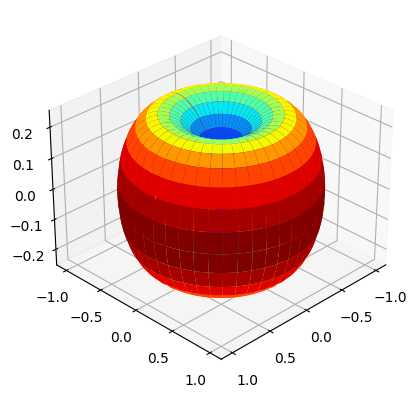

In [5]:
# Antenna Array at UE side
# antenna element type to be "OMNI"
# with single panel and 4 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI", 
                           centerFrequency = carrierFrequency,
                           arrayStructure  = np.array([1,1,2,2,1]))
                            
ueAntArray()

# num of Rx antenna elements
nr = ueAntArray.numAntennas
# Radiation Pattern of Rx antenna element 
ueAntArray.displayAntennaRadiationPattern()

**Antenna Array at Tx**

* We choose a parabolic antenna for Tx, for which we have to pass the string `"3GPP_38.901"` while instantiating `AntennaArrays` class.

* We pass `arrayStructure` of `[1,1,2,4,2]` meaning 1 panel in vertical direction, 1 panel in horizonatal direction, 2 antenna elements per column per panel, 4 columns per panel and 2 correspond to     antenna element being dual polarized. 

* With this structure, we obtain number of Tx antennas `nt` to be 16.

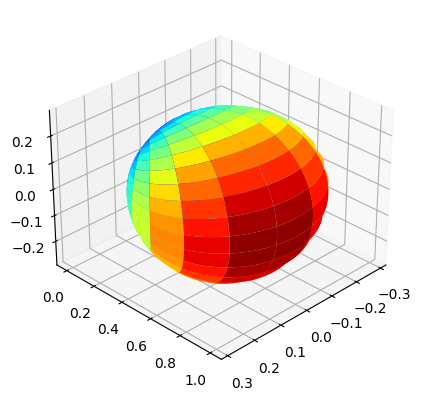

In [6]:
# Antenna Array at BS side
# antenna element type to be "3GPP_38.901", a parabolic antenna 
# with single panel and 8 dual polarized antenna element per panel.


bsAntArray = AntennaArrays(antennaType     = "3GPP_38.901", 
                           centerFrequency = carrierFrequency,
                           arrayStructure  = np.array([1,1,2,4,2]))
bsAntArray()

# num of Tx antenna elements
nt = bsAntArray.numAntennas
# Radiation Pattern of Tx antenna element 
bsAntArray.displayAntennaRadiationPattern()

## Node Mobility

Generate the route/trajectory for the mobile UE:

* All the Base Stations (BSs) are considered to be static and the User Equipments (UE) is mobile.

* The UE is moving at 0.833 m/s (3 kmph) on a circular trajectory of radius 250 meter centered around origin.

* For the UE, 60 snapshots are drawn while in motion on the circle with an interval of 5 sec.
    * The parameters are selected such that the UE complete the circumference of the circle.

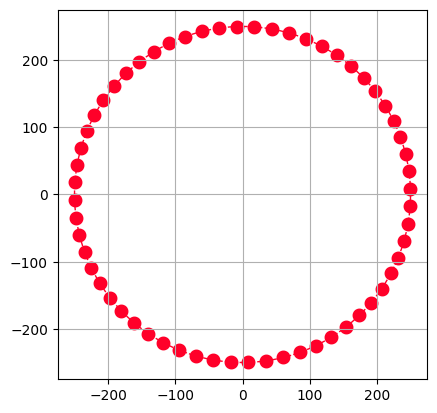

In [7]:
# NodeMobility parameters
# assuming that all the BSs are static and all the UEs are mobile.
# time values at each snapshot.

isInitLocationRandom    = True  # Initial location of the UE is random.
initAngle               = None  # Not required when isInitLocationRandom is True.
isInitOrientationRandom = False # UE Orientations are UE. Not randomized.
snapshotInterval        = 5     # 5 second

speed      = 0.833 # speed of the UE 3 Kmph
radius     = 250   # 3 Kmph
timeInst   = snapshotInterval*np.arange(nSnapShots, dtype=np.float32) 
UEroute    = NodeMobility("circular", nUEs, timeInst, radius, radius, 
                          speed, speed, isInitLocationRandom, initAngle, 
                          isInitOrientationRandom)
UEroute()
fig, ax    = UEroute.displayRoute()
ax.set_aspect(True)

## Simulation Layout

We define the simulation topology parametes:

 - ``ISD``: Inter Site Distance
 - ``minDist``: Minimum distance between transmitter and receiver.
 - ``bsHt``: BS heights 
 - ``ueHt``: UE heights
 - ``topology``: Simulation Topology
 - ``nSectorsPerSite``: Number of Sectors Per Site
 
Furthermore, users can access and update following parameters as per their requirements for channel using the handle simLayoutObj.x where x is:

 - The following parameters can be accessed or updated immendiately after object creation
    - ``UEtracks``
    - ``UELocations``
    - ``ueOrientation``
    - ``UEvelocityVector``
    - ``BStracks``
    - ``BSLocations``
    - ``bsOrientation``
    - ``BSvelocityVector``
    
 - The following parameters can be accessed or updated after calling the object
    - ``linkStateVec``
    
    

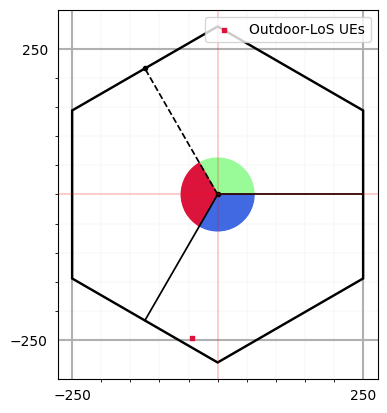

In [8]:
# Layout Parameters
isd             = 500         # inter site distance
minDist         = 35          # min distance between each UE and BS 
ueHt            = 1.5         # UE height
bsHt            = 35          # BS height
topology        = "Hexagonal" # BS layout type
nSectorsPerSite = 3           # number of sectors per site

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs, 
                                numOfUE = nUEs,
                                heightOfBS = bsHt, 
                                heightOfUE = ueHt,
                                ISD = isd, 
                                layoutType = topology, 
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = UEroute) 

# Update UE location for motion over a circle centered around the BS location.
simLayoutObj.UELocations = -simLayoutObj.UEtracks.mean(0)

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             forceLOS = True)

# displaying the topology of simulation layout

fig, ax = simLayoutObj.display2DTopology()
ax.scatter(simLayoutObj.UELocations[0,0]+simLayoutObj.UEtracks[:,0,0], 
               simLayoutObj.UELocations[0,1]+simLayoutObj.UEtracks[:,0,1],  color="k", zorder=-1)
ax.scatter(simLayoutObj.UELocations[0,0],simLayoutObj.UELocations[0,1], color="b", label = "UE-InitialLocation", zorder=-1)
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
ax.legend()
# plt.show()

## Channel Parameters,  Channel Coefficients and OFDM Channel

The UE can access the channel coefficents and other parameters using following handles:

- LSPs/SSPs: paramGenObj.x where x is
    - ``linkStateVec``
    - ``delaySpread``
    - ``phiAoA_LoS``, ``phiAoA_mn``, ``phiAoA_spread``
    - ``thetaAoA_LoS``, ``thetaAoA_mn``, ``thetaAoA_spread``
    - ``phiAoD_LoS``, ``phiAoD_mn``, ``phiAoD_spread``
    - ``thetaAoD_LoS``, ``thetaAoD_mn``, ``thetaAoD_spread``
    - ``xpr``
    - ``pathloss``, ``pathDelay``, ``pathPower``
    - ``shadowFading``
    
- Channel Co-efficeints: channel.x where x is
    - ``coefficients`` 
    - ``delays``

- Shape of OFDM Channel:
    - `Hf` is of shape : ``(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, Nfft, number of Rx antennas, number of Tx antennas)``

In [9]:
# Generate SSPs/LSPs Parameters: 
paramGenObj = simLayoutObj.getParameterGenerator()

# Generate Channel Coefficeints and Delays: SSPs/LSPs
channel = paramGenObj.getChannel(applyPathLoss = True)
# Channel coefficients can be accessed using: channel.coefficients
# Channel delays can be accessed using:       channel.delays

# Generate OFDM Channel
Nfft = 1024
Hf   = channel.ofdm(30*10**3, Nfft, simLayoutObj.carrierFrequency)

[Warning]: UE height 'hUE' cannot be less than 1! These values are forced to 1!
dBP (min, max): 2199.114990234375, 2199.114990234375


In [10]:
Hf.shape

(1, 60, 3, 1, 1024, 4, 16)

## Variation in Channel Power across Time

* The following code snippets displays the variation of received power of a UE when moves on a circular track (centered around origin) starting from its `initial position`.
* In the current simulation we have 3 BSs and 1 UE moving on a circular track starting from a random intitial position inside a hexagonal layout.

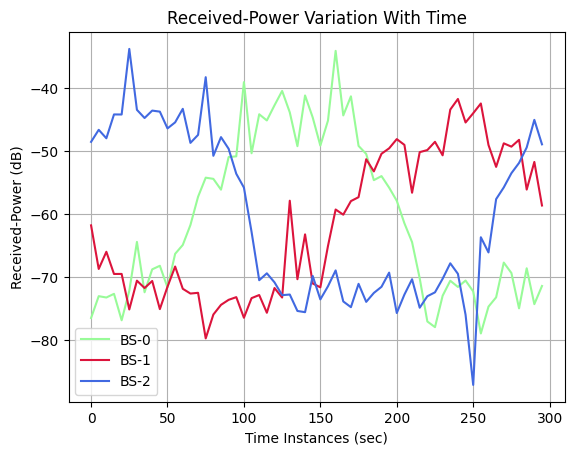

In [11]:
fig, ax = plt.subplots()
power   = 10*np.log10(((np.abs(Hf)**2).sum(axis=0).sum(axis=2).sum(axis=2).sum(axis=2).sum(axis=2))/(nr*nt))
colors  = np.array(['palegreen', 'crimson','royalblue'])
ax.plot(timeInst, power[:,0], colors[0], label = "BS-0")
ax.plot(timeInst, power[:,1], colors[1], label = "BS-1")
ax.plot(timeInst, power[:,2], colors[2], label = "BS-2")

ax.legend()
ax.grid()
ax.set_xlabel('Time Instances (sec)')
ax.set_ylabel('Received-Power (dB)')
ax.set_title('Received-Power Variation With Time', fontsize=12)

plt.show()

## Animation
### Functions to Animate the Plot

In [12]:
def wrapTo30(ang):
    # Function to wrap angles not exceeding 30 degree.
    ang = np.mod(ang, np.pi/3)
    return np.where(ang>np.pi/6, ang-np.pi/3, ang)

def plotLayout(ax):
    scale   = 8
    colors  = np.array(['palegreen', 'crimson', 'royalblue', 'gold', 'midnightblue', 'purple','orange','lightcoral'])
    delAngle = 360/nSectorsPerSite
    numSites = int(nBSs/nSectorsPerSite)
    simLayoutObj.BSLocations

    mark = ['c--', 'm:', 'y-']
    # Add some coloured hexagons
    for idx in range(numSites):
    #     color = c[0]
        hex   = patches.RegularPolygon((simLayoutObj.BSLocations[0,idx], simLayoutObj.BSLocations[1,idx]), numVertices=6, 
                                       radius=isd/np.sqrt(3),orientation=np.radians(120), 
                                       facecolor = 'none',alpha=1, edgecolor='k', lw = 1.75)
        ax.add_patch(hex)
        # Also add a text label
        for n in range(nSectorsPerSite):

            sector = patches.Wedge((simLayoutObj.BSLocations[0,idx], simLayoutObj.BSLocations[1,idx]),         # (x,y)
                                   isd/scale,      # radius
                                   n*delAngle,     # theta1 (in degrees)
                                   (n+1)*delAngle, # theta2
                                   color=colors[n%8], 
                                   alpha=1)
            ax.add_patch(sector)
            if(nSectorsPerSite != 1):
                boundDistance = isd*np.sqrt(5/12-(1/6)*np.abs(np.cos(2*wrapTo30(n*delAngle*np.pi/180))))
                ax.plot([simLayoutObj.BSLocations[0,idx], simLayoutObj.BSLocations[0,idx] + boundDistance*np.cos(n*delAngle*np.pi/180)], 
                        [simLayoutObj.BSLocations[1,idx], simLayoutObj.BSLocations[1,idx] + boundDistance*np.sin(n*delAngle*np.pi/180)], 
                        mark[n%3], lw=2, label = "Sector "+ str(n) + "-->"+str((n+1)%3) + " Boundary")


# function that draws each frame of the animation
def animate(i):
    
    x.append(timeInst[i])
    y0.append(power[:,0][i])    
    y1.append(power[:,1][i])    
    y2.append(power[:,2][i])

    ax[0].clear()
    ax[0].grid()
    ax[0].plot(x, y0, color='palegreen')
    ax[0].plot(x, y1, color='crimson')
    ax[0].plot(x, y2, color='royalblue')
    ax[0].set_xlim([0, timeInst[-1]])
    ax[0].set_ylim([-100, 10])
#     ax[0].margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center 
    
    ax[0].scatter(timeInst[i], power[:,0][i],  color ='palegreen', label = "Received-Power from BS-0")
    ax[0].scatter(timeInst[i], power[:,1][i],  color ='crimson',   label = "Received-Power from BS-1")
    ax[0].scatter(timeInst[i], power[:,2][i],  color ='royalblue', label = "Received-Power from BS-2")
    ax[0].axvline(x = timeInst[10], color ='c', ls = "--", lw = 2, label = "Sector 0-->1 Boundary")
    ax[0].axvline(x = timeInst[30], color ='m', ls = ":",  lw = 2, label = "Sector 1-->2 Boundary")
    ax[0].axvline(x = timeInst[50], color ='y',            lw = 2, label = "Sector 2-->0 Boundary")
   
    ax[0].set_xlabel('Time Instances (sec)')
    ax[0].set_ylabel('Received-Power (dB)')
    ax[0].set_title('Received-Power Variation With Time', fontsize=12)
    ax[0].legend()
        
    ax[1].clear()
    ax[1].grid()
    ax[1].scatter(simLayoutObj.UELocations[0,0]+simLayoutObj.UEtracks[0:i,0,0], 
                  simLayoutObj.UELocations[0,1]+simLayoutObj.UEtracks[0:i,0,1], color="k", zorder=-1, label = "UE's Past Locations")
    ax[1].scatter(simLayoutObj.UELocations[0,0]+simLayoutObj.UEtracks[i,0,0], 
                  simLayoutObj.UELocations[0,1]+simLayoutObj.UEtracks[i,0,1],   color="r", zorder=-1, label = "UE's Current Locations")
    ax[1].scatter(simLayoutObj.UELocations[0,0],simLayoutObj.UELocations[0,1],  color="b", zorder=-1, label = "UE's Start Loaction")
    plotLayout(ax[1])
    ax[1].set_xlabel('x-coordinates (m)')
    ax[1].set_ylabel('y-coordinates (m)')
    ax[1].set_title('Simulation Layout', fontsize=12)
    ax[1].legend()
    ax[1].set_xlim([-300, 300])
    ax[1].set_ylim([-300, 300])
#     ax[1].margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center 
    

### Simulation Animation

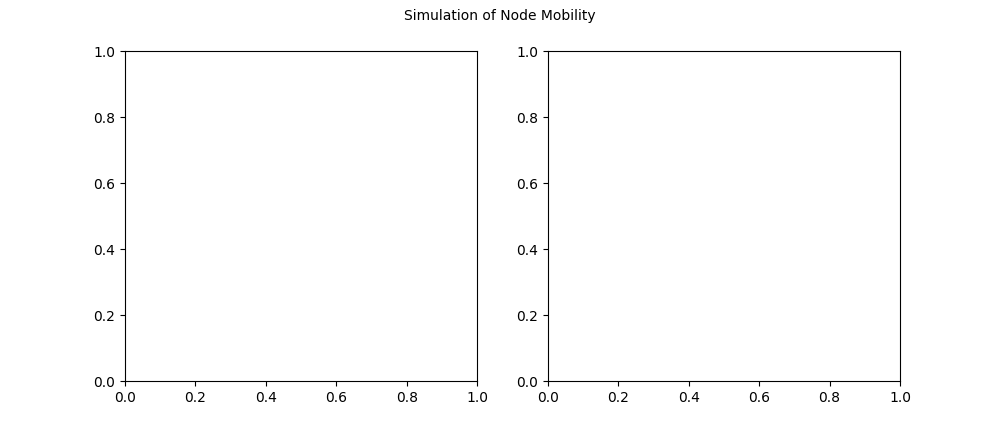

In [13]:
# create the figure and axes objects
scaleFig = 1.75
fig, ax  = plt.subplots(1,2,figsize=(17.5/scaleFig,7.5/scaleFig))
fig.suptitle('Simulation of Node Mobility', fontsize=10)


# ax[0].set_aspect('equal')
# ax[1].set_aspect('equal')
# create empty lists for the x and y data
x  = []
y0 = []
y1 = [] 
y2 = []
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=timeInst.shape[0], interval=100, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=30)
# anim.save('SimulationOfNodeMobility.mp4', writer=writervideo)
# anim.save('SimulationOfNodeMobility.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

![Alt Text](mobility.gif)

### Further Study

* Simulate by increasing number of UEs `nUEs` greater than 1 and see how the power varies with time for each mobile user.
* Increase number of carrier frequencies to be grater than 1 and see how carrier frequency effects the power.
* Simulate the same channel for `NLOS` links as well by making `forceLOS = False` and see how the performance change.